# Imports 

In [ ]:
import numpy as np
import pandas as pd
from shapely.geometry import Point
!pip install geopandas
import geopandas as gpd
from geopandas import GeoDataFrame
!pip3 install pandas_profiling --upgrade
import pandas_profiling

import logging # to further silence deprecation warnings
logging.captureWarnings(True)

import itertools

from tqdm.notebook import tqdm as tqdm

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly
print(f"plotly.__version__: {plotly.__version__}")

import seaborn as sns

## sklearn

In [100]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder,\
        MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors, kneighbors_graph

from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.cluster import AgglomerativeClustering, Birch
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score,\
       adjusted_mutual_info_score, silhouette_score, silhouette_samples,\
       make_scorer, homogeneity_score, completeness_score, v_measure_score,\
       davies_bouldin_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline


In [101]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['figure.facecolor'] = 'white'

plt.style.use('seaborn-white')

In [ ]:
!pip install clusteval
!pip install hdbscan
!pip install Amazon-DenseClus
from denseclus import DenseClus
import hdbscan
# Import library
from clusteval import clusteval


# Dataset


## Read data

In [ ]:
!pip install bds_courseware
from bds_courseware import read_drive_dataset
from bds_courseware import print_dataset_description, print_module_datasets
from bds_courseware import HOMEWORK_DATASETS
print('Dataset names:', HOMEWORK_DATASETS.keys())
name = 'quake';
df = read_drive_dataset(*HOMEWORK_DATASETS[name])
print(df.head(2))
print(df.shape)

# EDA

In [104]:
df.head()

,Focal depth,Latitude,Longitude,Richter
0,33,-52.26,28.30,6.7
1,36,45.53,150.93,5.8
2,57,41.85,142.78,5.8
3,67,29.19,141.15,6.2
4,30,-21.66,169.81,6.0


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Focal depth  2178 non-null   int64  
 1   Latitude     2178 non-null   float64
 2   Longitude    2178 non-null   float64
 3   Richter      2178 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 68.2 KB


We can see that there are no obvious data missing and data types are alright

## Variables

In [106]:
profile = pandas_profiling.ProfileReport(df)
profile.to_file('profile.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]


'soft_unicode' has been renamed to 'soft_str'. The old name will be removed in MarkupSafe 2.1.



'soft_unicode' has been renamed to 'soft_str'. The old name will be removed in MarkupSafe 2.1.



'soft_unicode' has been renamed to 'soft_str'. The old name will be removed in MarkupSafe 2.1.



'soft_unicode' has been renamed to 'soft_str'. The old name will be removed in MarkupSafe 2.1.




Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Everything looks alright on the first glance

## Duplicates

In [107]:
df.duplicated().sum()

1

In [108]:
df.drop_duplicates(inplace=True)

## Richter scale

I decided to make richter scale categorial variable because scale is logarithmic and there isn't much variation anyway (no minor or major Earthquakes in the dataset). HBSCAN requres a categorical feature, so I have to make a copy of the dataframe and skip transformers for this algorythm

In [109]:
df['Richter'] = pd.cut(x=df['Richter'],
                     bins=[2.5, 3, 4, 5, 6, 7, 8, np.inf ],
                     labels=['Miniature', 'Minor', 'Light', 'Moderate', 'Strong', 'Major', 'Great'])

df.Richter.value_counts()

Moderate     1578
Strong        599
Miniature       0
Minor           0
Light           0
Major           0
Great           0
Name: Richter, dtype: int64

In [110]:
df_dens = df.copy()

# Modelling

## Preprocessor pipeline

For the clustering algorithms that are working with a distance we need to scale the features

In [111]:
print('Shape before the transformation:')
print(df.shape)

num_cols = df.select_dtypes(include=['int','float']).columns
cat_cols = df.select_dtypes(exclude=['int','float']).columns

num_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder()),
])

preprocessor = ColumnTransformer(
    transformers=[
      ('num', num_pipeline, num_cols),
      ('cat', cat_pipeline, cat_cols),
    
])

pipeline = make_pipeline(
    preprocessor,
)


df_tr = pipeline.fit_transform(df)

print('Shape after the transformation:')
print(df_tr.shape)


Shape before the transformation:
(2177, 4)
Shape after the transformation:
(2177, 5)


In [112]:
df_tr[:10]

array([[0.05030488, 0.09838219, 0.57856428, 0.        , 1.        ],
       [0.05487805, 0.77447456, 0.91924103, 1.        , 0.        ],
       [0.08689024, 0.74903208, 0.89659962, 1.        , 0.        ],
       [0.10213415, 0.66150442, 0.89207134, 0.        , 1.        ],
       [0.04573171, 0.30994192, 0.9716913 , 1.        , 0.        ],
       [0.        , 0.61933075, 0.8349261 , 0.        , 1.        ],
       [0.21189024, 0.31657909, 0.97199689, 0.        , 1.        ],
       [0.09146341, 0.61407633, 0.75991777, 1.        , 0.        ],
       [0.07621951, 0.36538993, 0.96099567, 1.        , 0.        ],
       [0.18140244, 0.34693031, 0.30086676, 1.        , 0.        ]])

## PCA

In [113]:
pca = PCA(n_components=2)

X_2d = pca.fit_transform(df_tr)

In [114]:
df['pca_x'], df['pca_y'] = X_2d[:, 0], X_2d[:, 1]

In [115]:
fig = px.scatter(df, x='pca_x', y='pca_y')
fig.update_layout(title='Quakes in 2d PCA space')
fig.show()

Obviously there are separation by two categories of earthquakes right now - by richter feature

## Silhouette Scorer

In [116]:
def silhouette_scorer(estimator, X):
    clusters = estimator.fit(X)
    if(len(set(clusters.labels_))==1):
      return 0
    else:
      score = silhouette_score(X, clusters.labels_)
      return score

## Density Based Clustering Validation 

Density Based Clustering Validation or DBCV works for desnity-based clustering algorithms precisely because it takes noise into account and captures the shape property of clusters via densities and not distances (see the original paper)

As the paper explains, the final result of DBCV is a weighted sum of “Validity Index” values of clusters. This produces a score between -1 to 1, with the larger the value the better clustering solution.

I took ready implementattion from https://github.com/christopherjenness/DBCV/ but as a scorer it gave a bad result with DBScan and HBSCAN has its own scorer implemented inside the library. 

In [117]:
"""
Implimentation of Density-Based Clustering Validation "DBCV"

Citation:
Moulavi, Davoud, et al. "Density-based clustering validation."
Proceedings of the 2014 SIAM International Conference on Data Mining.
Society for Industrial and Applied Mathematics, 2014.
"""

import numpy as np
from scipy.spatial.distance import euclidean, cdist
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csgraph


def DBCV(X, labels, dist_function=euclidean):
    """
    Density Based clustering validation

    Args:
        X (np.ndarray): ndarray with dimensions [n_samples, n_features]
            data to check validity of clustering
        labels (np.array): clustering assignments for data X
        dist_dunction (func): function to determine distance between objects
            func args must be [np.array, np.array] where each array is a point

    Returns: cluster_validity (float)
        score in range[-1, 1] indicating validity of clustering assignments
    """
    graph = _mutual_reach_dist_graph(X, labels, dist_function)
    mst = _mutual_reach_dist_MST(graph)
    cluster_validity = _clustering_validity_index(mst, labels)
    return cluster_validity


def _core_dist(point, neighbors, dist_function):
    """
    Computes the core distance of a point.
    Core distance is the inverse density of an object.

    Args:
        point (np.array): array of dimensions (n_features,)
            point to compute core distance of
        neighbors (np.ndarray): array of dimensions (n_neighbors, n_features):
            array of all other points in object class
        dist_dunction (func): function to determine distance between objects
            func args must be [np.array, np.array] where each array is a point

    Returns: core_dist (float)
        inverse density of point
    """
    n_features = np.shape(point)[0]
    n_neighbors = np.shape(neighbors)[0]

    distance_vector = cdist(point.reshape(1, -1), neighbors)
    distance_vector = distance_vector[distance_vector != 0]
    numerator = ((1/distance_vector)**n_features).sum()
    core_dist = (numerator / (n_neighbors - 1)) ** (-1/n_features)
    return core_dist


def _mutual_reachability_dist(point_i, point_j, neighbors_i,
                              neighbors_j, dist_function):
    """.
    Computes the mutual reachability distance between points

    Args:
        point_i (np.array): array of dimensions (n_features,)
            point i to compare to point j
        point_j (np.array): array of dimensions (n_features,)
            point i to compare to point i
        neighbors_i (np.ndarray): array of dims (n_neighbors, n_features):
            array of all other points in object class of point i
        neighbors_j (np.ndarray): array of dims (n_neighbors, n_features):
            array of all other points in object class of point j
        dist_dunction (func): function to determine distance between objects
            func args must be [np.array, np.array] where each array is a point

    Returns: mutual_reachability (float)
        mutual reachability between points i and j

    """
    core_dist_i = _core_dist(point_i, neighbors_i, dist_function)
    core_dist_j = _core_dist(point_j, neighbors_j, dist_function)
    dist = dist_function(point_i, point_j)
    mutual_reachability = np.max([core_dist_i, core_dist_j, dist])
    return mutual_reachability


def _mutual_reach_dist_graph(X, labels, dist_function):
    """
    Computes the mutual reach distance complete graph.
    Graph of all pair-wise mutual reachability distances between points

    Args:
        X (np.ndarray): ndarray with dimensions [n_samples, n_features]
            data to check validity of clustering
        labels (np.array): clustering assignments for data X
        dist_dunction (func): function to determine distance between objects
            func args must be [np.array, np.array] where each array is a point

    Returns: graph (np.ndarray)
        array of dimensions (n_samples, n_samples)
        Graph of all pair-wise mutual reachability distances between points.

    """
    n_samples = np.shape(X)[0]
    graph = []
    counter = 0
    for row in range(n_samples):
        graph_row = []
        for col in range(n_samples):
            point_i = X[row]
            point_j = X[col]
            class_i = labels[row]
            class_j = labels[col]
            members_i = _get_label_members(X, labels, class_i)
            members_j = _get_label_members(X, labels, class_j)
            dist = _mutual_reachability_dist(point_i, point_j,
                                             members_i, members_j,
                                             dist_function)
            graph_row.append(dist)
        counter += 1
        graph.append(graph_row)
    graph = np.array(graph)
    return graph


def _mutual_reach_dist_MST(dist_tree):
    """
    Computes minimum spanning tree of the mutual reach distance complete graph

    Args:
        dist_tree (np.ndarray): array of dimensions (n_samples, n_samples)
            Graph of all pair-wise mutual reachability distances
            between points.

    Returns: minimum_spanning_tree (np.ndarray)
        array of dimensions (n_samples, n_samples)
        minimum spanning tree of all pair-wise mutual reachability
            distances between points.
    """
    mst = minimum_spanning_tree(dist_tree).toarray()
    return mst + np.transpose(mst)


def _cluster_density_sparseness(MST, labels, cluster):
    """
    Computes the cluster density sparseness, the minimum density
        within a cluster

    Args:
        MST (np.ndarray): minimum spanning tree of all pair-wise
            mutual reachability distances between points.
        labels (np.array): clustering assignments for data X
        cluster (int): cluster of interest

    Returns: cluster_density_sparseness (float)
        value corresponding to the minimum density within a cluster
    """
    indices = np.where(labels == cluster)[0]
    cluster_MST = MST[indices][:, indices]
    cluster_density_sparseness = np.max(cluster_MST)
    return cluster_density_sparseness


def _cluster_density_separation(MST, labels, cluster_i, cluster_j):
    """
    Computes the density separation between two clusters, the maximum
        density between clusters.

    Args:
        MST (np.ndarray): minimum spanning tree of all pair-wise
            mutual reachability distances between points.
        labels (np.array): clustering assignments for data X
        cluster_i (int): cluster i of interest
        cluster_j (int): cluster j of interest

    Returns: density_separation (float):
        value corresponding to the maximum density between clusters
    """
    indices_i = np.where(labels == cluster_i)[0]
    indices_j = np.where(labels == cluster_j)[0]
    shortest_paths = csgraph.dijkstra(MST, indices=indices_i)
    relevant_paths = shortest_paths[:, indices_j]
    density_separation = np.min(relevant_paths)
    return density_separation


def _cluster_validity_index(MST, labels, cluster):
    """
    Computes the validity of a cluster (validity of assignmnets)

    Args:
        MST (np.ndarray): minimum spanning tree of all pair-wise
            mutual reachability distances between points.
        labels (np.array): clustering assignments for data X
        cluster (int): cluster of interest

    Returns: cluster_validity (float)
        value corresponding to the validity of cluster assignments
    """
    min_density_separation = np.inf
    for cluster_j in np.unique(labels):
        if cluster_j != cluster:
            cluster_density_separation = _cluster_density_separation(MST,
                                                                     labels,
                                                                     cluster,
                                                                     cluster_j)
            if cluster_density_separation < min_density_separation:
                min_density_separation = cluster_density_separation
    cluster_density_sparseness = _cluster_density_sparseness(MST,
                                                             labels,
                                                             cluster)
    numerator = min_density_separation - cluster_density_sparseness
    denominator = np.max([min_density_separation, cluster_density_sparseness])
    cluster_validity = numerator / denominator
    return cluster_validity


def _clustering_validity_index(MST, labels):
    """
    Computes the validity of all clustering assignments for a
    clustering algorithm

    Args:
        MST (np.ndarray): minimum spanning tree of all pair-wise
            mutual reachability distances between points.
        labels (np.array): clustering assignments for data X

    Returns: validity_index (float):
        score in range[-1, 1] indicating validity of clustering assignments
    """
    n_samples = len(labels)
    validity_index = 0
    for label in np.unique(labels):
        fraction = np.sum(labels == label) / float(n_samples)
        cluster_validity = _cluster_validity_index(MST, labels, label)
        validity_index += fraction * cluster_validity
    return validity_index


def _get_label_members(X, labels, cluster):
    """
    Helper function to get samples of a specified cluster.

    Args:
        X (np.ndarray): ndarray with dimensions [n_samples, n_features]
            data to check validity of clustering
        labels (np.array): clustering assignments for data X
        cluster (int): cluster of interest

    Returns: members (np.ndarray)
        array of dimensions (n_samples, n_features) of samples of the
        specified cluster.
    """
    indices = np.where(labels == cluster)[0]
    members = X[indices]
    return members


## Similarity scores

In [118]:
def similarity_scores(y_kmeans, labels):
  print("Homogeneity: %0.3f" % homogeneity_score(y_kmeans, labels))
  print("Completeness: %0.3f" % completeness_score(y_kmeans, labels))
  print("V-measure: %0.3f" % v_measure_score(y_kmeans, labels))
  print("Adjusted Rand Index: %0.3f" % adjusted_rand_score(y_kmeans, labels))
  print(
      "Adjusted Mutual Information: %0.3f"
      % adjusted_mutual_info_score(y_kmeans, labels)
  )

## Cluster quality scores

In [119]:
def cluster_quality(n_clusters, X, cluster_labels):
  print("Estimated number of clusters: %d"%n_clusters)  
  print("Silhouette Coefficient (Close to 1 the best): %0.3f" % silhouette_score(X, cluster_labels))
  print("Calinski-Harabasz Index (The higher the better): %0.3f" % calinski_harabasz_score(X, cluster_labels))
  print("Davies-Bouldin Index (Close to 0 the best): %0.3f" % davies_bouldin_score(X, cluster_labels))

## K-Means

### 15 clusters

I was asked to build a K-Means with 15 cclusters

In [120]:
kmeans = KMeans(n_clusters=15, random_state=0)
y_kmeans_15 = kmeans.fit_predict(df_tr)
#df['kmeans_15_label'] = pd.Series(y_kmeans_15)

In [121]:
fig = px.scatter(df, x='pca_x', y='pca_y', color=y_kmeans_15)
fig.update_layout(title='Quakes in 2d PCA space (KMeans labels with 15 clusters)')
fig.show()

Looks a bit messy, but we can see that there are some cluster separation between two strength groups.

#### Clustering quality

In [122]:
cluster_quality(15, df_tr, y_kmeans_15)

Estimated number of clusters: 15
Silhouette Coefficient (Close to 1 the best): 0.451
Calinski-Harabasz Index (The higher the better): 4249.823
Davies-Bouldin Index (Close to 0 the best): 0.784


### Inertia and scree plot

Let's try to find the best number of clusters using inertia:

In [123]:
Sum_of_squared_distances = []
K = range(5,25)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_tr)
    Sum_of_squared_distances.append(km.inertia_)

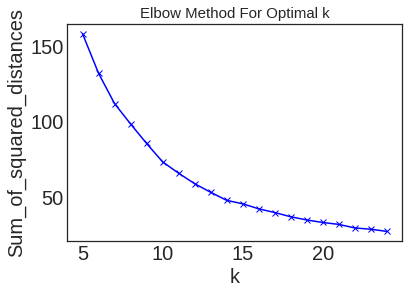

In [124]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

There is no obvious elbow present, but it looks like that the optimal number of clusters is between 10 and 15

### Clusteval (silhouette)

Let's try to find the best nmber of clusters using the silhouette score


[clusteval] >Fit using kmeans with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|██████████| 23/23 [00:34<00:00,  1.51s/it]


[clusteval] >Optimal number clusters detected: [2].
[clusteval] >Fin.


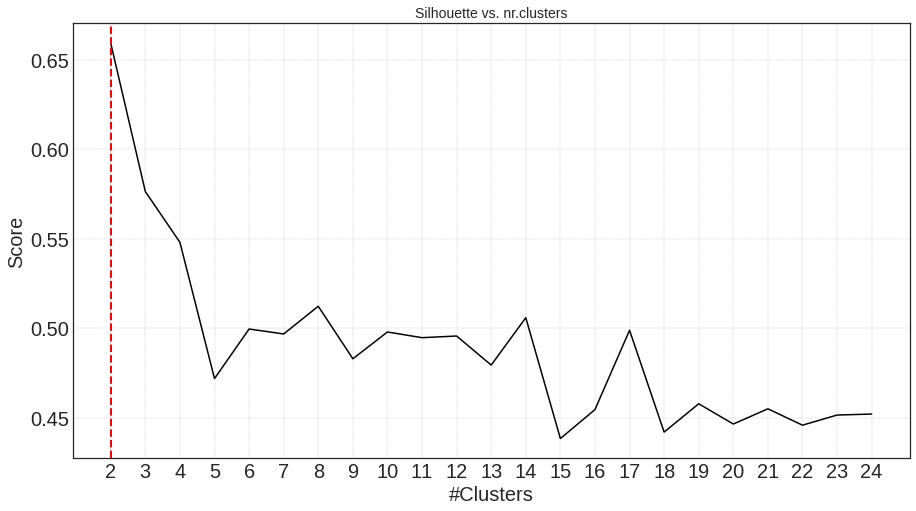

[clusteval] >Estimated number of n_clusters: 1, average silhouette_score=0.659


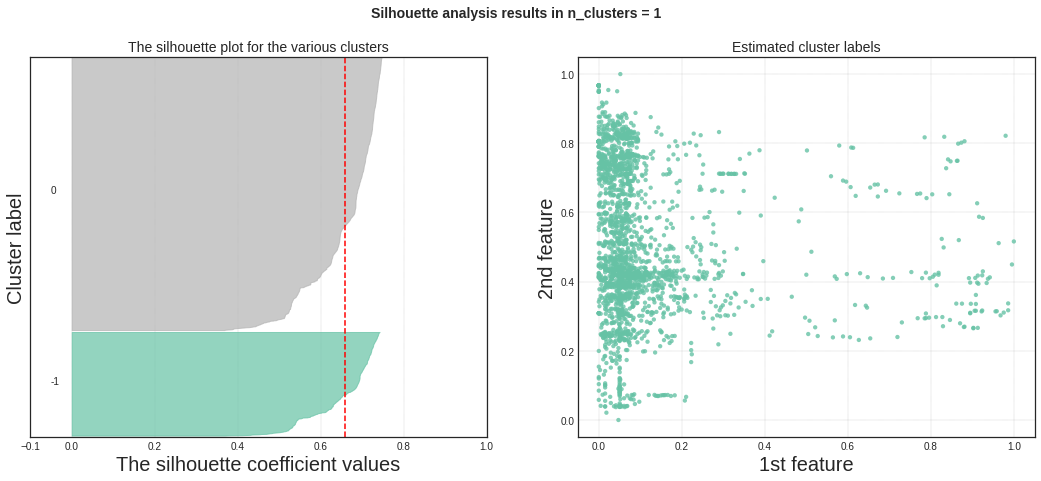

In [125]:
# Set parameters, as an example dbscan
ce = clusteval(evaluate='silhouette', cluster='kmeans')

# Fit to find optimal number of clusters using dbscan
results= ce.fit(df_tr)

# Make plot of the cluster evaluation
ce.plot()

# Make scatter plot. Note that the first two coordinates are used for plotting.
ce.scatter(df_tr)

# results is a dict with various output statistics. One of them are the labels.
cluster_labels = results['labx']

Actually it looks like 3 or 8 clusters would be a good choice here. I decided to make 3 clusters

#### Clustering quality

In [126]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans_labels = kmeans.fit_predict(df_tr)
df['kmeans'] = pd.Series(kmeans_labels)

cluster_quality(n_clusters, df_tr, kmeans_labels)

Estimated number of clusters: 3
Silhouette Coefficient (Close to 1 the best): 0.576
Calinski-Harabasz Index (The higher the better): 4509.632
Davies-Bouldin Index (Close to 0 the best): 0.677


In [127]:
fig = px.scatter(df, x='pca_x', y='pca_y', color='kmeans')
fig.update_layout(title=f'Quakes in 2d PCA space (KMeans labels with {n_clusters} clusters)')
fig.show()

With three clusters we can see very clear separation with some noice points. 

## Affinity propagation

Dataset is fairly small so I can afford to try out Affinity Propagation algorythm. 

In [128]:
%%time

af = AffinityPropagation()

grid = {
    'preference': [None, -100, -500],
    'damping': np.linspace(0.5, 1.0, 5),
}

gs = GridSearchCV(af, grid, cv=3, scoring=silhouette_scorer)
gs.fit(df_tr)

CPU times: user 4min 33s, sys: 8.83 s, total: 4min 42s
Wall time: 4min 42s


GridSearchCV(cv=3, estimator=AffinityPropagation(),
             param_grid={'damping': array([0.5  , 0.625, 0.75 , 0.875, 1.   ]),
                         'preference': [None, -100, -500]},
             scoring=<function silhouette_scorer at 0x7f1bd9ff29d0>)

### Clustering quality

In [129]:
print("Best estimator: %s"%gs.best_estimator_)
print("Best score: %0.3f"%gs.best_score_)

n_clusters = len(gs.best_estimator_.cluster_centers_indices_)
cluster_labels = gs.best_estimator_.fit_predict(df_tr)

cluster_quality(n_clusters, df_tr, cluster_labels)


Best estimator: AffinityPropagation(damping=0.75, preference=-100)
Best score: 0.660
Estimated number of clusters: 3
Silhouette Coefficient (Close to 1 the best): 0.573
Calinski-Harabasz Index (The higher the better): 4493.954
Davies-Bouldin Index (Close to 0 the best): 0.686


If we look at the best_score the result is better than K-Means, but silhouette_score metrics gives a very different result indeed, as well as other metrics. Let's compare similarity to K-Means clustering

### Similarity scores

In [130]:
kmeans = KMeans(n_clusters=3, random_state=0)
y_kmeans = kmeans.fit_predict(df_tr)

af = AffinityPropagation(preference=-100, random_state=0, damping=0.875).fit(df_tr)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
df['affinity'] = af.labels_

similarity_scores(y_kmeans, labels)

Homogeneity: 0.978
Completeness: 0.975
V-measure: 0.977
Adjusted Rand Index: 0.986
Adjusted Mutual Information: 0.977


We can see that these two algorythms give very similar resuls - results close to 1


## Spectral clustering

It is written in the documentation that spectral clustering works well only with small amount of clusters, so I will try it with 7-11 clusters

In [131]:
spectral = SpectralClustering(eigen_solver="arpack", affinity="nearest_neighbors" )
grid = {
    'n_clusters': np.arange(3,12),
}

gs = GridSearchCV(spectral, grid, cv=3, scoring=silhouette_scorer)
gs.fit(df_tr)

GridSearchCV(cv=3,
             estimator=SpectralClustering(affinity='nearest_neighbors',
                                          eigen_solver='arpack'),
             param_grid={'n_clusters': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11])},
             scoring=<function silhouette_scorer at 0x7f1bd9ff29d0>)

### Clustering quality

In [132]:
print("Best estimator: %s"%gs.best_estimator_)
print("Best score: %0.3f"%gs.best_score_)

n_clusters = gs.best_estimator_.n_clusters
cluster_labels = gs.best_estimator_.fit_predict(df_tr)

cluster_quality(n_clusters, df_tr, cluster_labels)

Best estimator: SpectralClustering(affinity='nearest_neighbors', eigen_solver='arpack',
                   n_clusters=3)
Best score: 0.546
Estimated number of clusters: 3
Silhouette Coefficient (Close to 1 the best): 0.483
Calinski-Harabasz Index (The higher the better): 2154.851
Davies-Bouldin Index (Close to 0 the best): 0.550


Not the best results so far

## Agglomerative clustering


[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|██████████| 23/23 [00:03<00:00,  5.94it/s]


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [2].
[clusteval] >Fin.


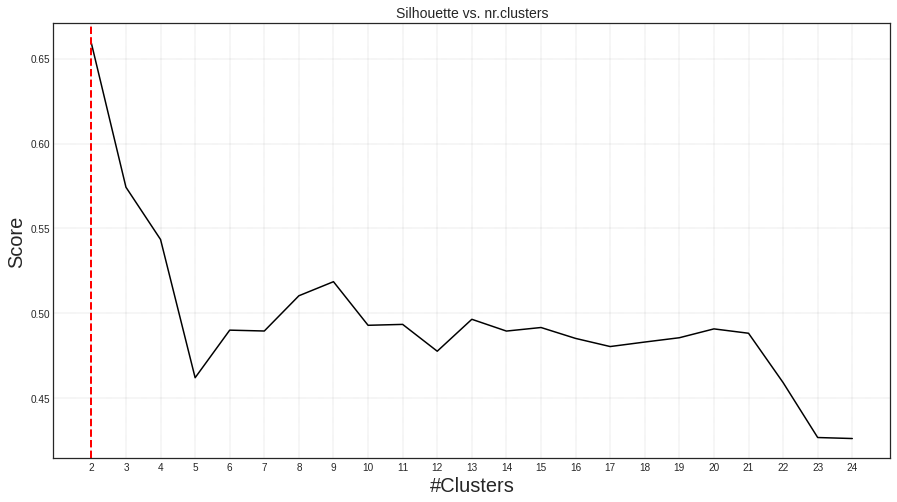

[clusteval] >Estimated number of n_clusters: 2, average silhouette_score=0.659


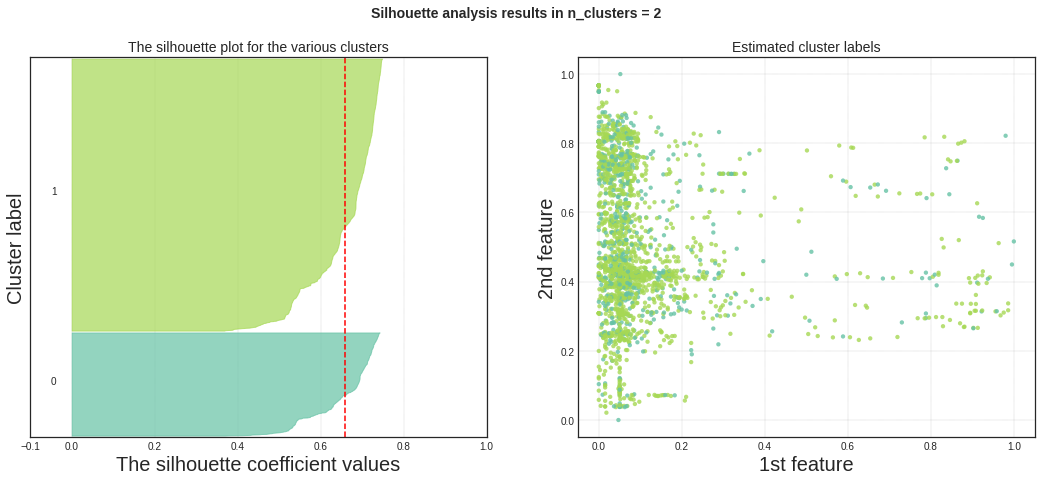

In [133]:
# Set parameters, as an example dbscan
ce = clusteval(evaluate='silhouette', cluster='agglomerative')

# Fit to find optimal number of clusters using dbscan
results= ce.fit(df_tr)

# Make plot of the cluster evaluation
ce.plot()

# Make scatter plot. Note that the first two coordinates are used for plotting.
ce.scatter(df_tr)

# results is a dict with various output statistics. One of them are the labels.
cluster_labels = results['labx']

Result is very similar to KMeans and Affinity. Let's see the dendrogramm

[clusteval] >Plotting the dendrogram with optimized settings: metric=euclidean, linkage=ward, max_d=29.657. Be patient now..
[clusteval] >Compute cluster labels.


{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [12.5, 12.5, 42.5, 42.5],
  [65.0, 65.0, 75.0, 75.0],
  [85.0, 85.0, 95.0, 95.0],
  [70.0, 70.0, 90.0, 90.0],
  [125.0, 125.0, 135.0, 135.0],
  [115.0, 115.0, 130.0, 130.0],
  [145.0, 145.0, 155.0, 155.0],
  [122.5, 122.5, 150.0, 150.0],
  [105.0, 105.0, 136.25, 136.25],
  [195.0, 195.0, 205.0, 205.0],
  [185.0, 185.0, 200.0, 200.0],
  [175.0, 175.0, 192.5, 192.5],
  [165.0, 165.0, 183.75, 183.75],
  [120.625, 120.625, 174.375, 174.375],
  [80.0, 80.0, 147.5, 147.5],
  [215.0, 215.0, 225.0, 225.0],
  [235.0, 235.0, 245.0, 245.0],
  [255.0, 255.0, 265.0, 265.0],
  [240.0, 240.0, 260.0, 260.0],
  [220.0, 220.0, 250.0, 250.0],
  [285.0, 285.0, 295.0, 295.0],
  [315.0, 315.0, 325.0, 325.0],
  [305.0, 305.0, 320.0, 320.0],
  [290.0, 290.0, 312.5, 312.5],
  [275.0, 275.0, 301.25, 301.25],
  [335.0, 335.0, 345.0, 345.0],
  [375.0, 375.0, 385.0, 385.0],
  [365.0, 365.0, 380

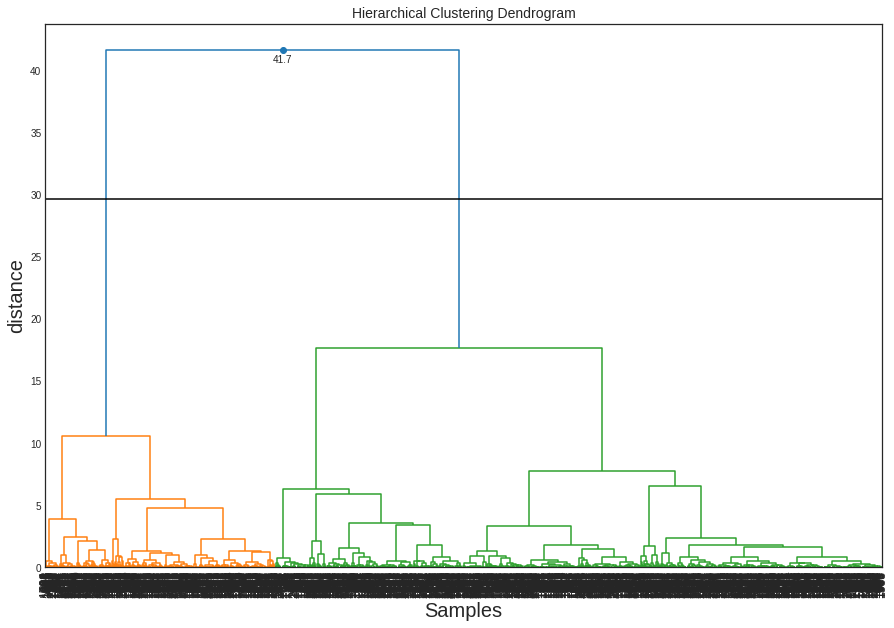

In [134]:
ce.dendrogram()

### Clustering quality

In [135]:
# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
  df_tr, n_neighbors=10, include_self=False
)

al = AgglomerativeClustering(
        linkage="ward",
        n_clusters=3,
        connectivity=connectivity,
    ).fit(df_tr)
labels = al.labels_

cluster_quality(3, df_tr, labels)

Estimated number of clusters: 3
Silhouette Coefficient (Close to 1 the best): 0.568
Calinski-Harabasz Index (The higher the better): 4448.769
Davies-Bouldin Index (Close to 0 the best): 0.695


### Similarity scores

Let's see the similarity with KMeans

In [136]:
kmeans = KMeans(n_clusters=3, random_state=0)
y_kmeans = kmeans.fit_predict(df_tr)

similarity_scores(y_kmeans, labels)

Homogeneity: 0.960
Completeness: 0.952
V-measure: 0.956
Adjusted Rand Index: 0.969
Adjusted Mutual Information: 0.956


We can see that hierarchicl clustering gives very similar result with KMeans

## HBSCAN

Don't have time to make it work for now

In [137]:
clf = DenseClus(
    random_state=10,
    umap_combine_method="intersection_union_mapper"
)

clf.fit(df_dens)


gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable




Cluster compositions

In [138]:
embedding = clf.mapper_.embedding_
labels = clf.score()
clustered = (labels >= 0)

cnts = pd.DataFrame(labels)[0].value_counts()
cnts = cnts.reset_index()
cnts.columns = ['cluster','count']
print(cnts.sort_values(['cluster']))

   cluster  count
5       -1     64
3        0    296
2        1    477
4        2    116
0        3    741
1        4    483


We can see 5 clusters with noise here 

In [139]:
coverage = np.sum(clustered) / embedding.shape[0]

print(f"Coverage {coverage:.3f}")
print(f"DBCV score {clf.hdbscan_.relative_validity_:.3f}")

n_clusters = len(set(labels)) - 1
cluster_quality(n_clusters, embedding, labels)

Coverage 0.971
DBCV score 0.208
Estimated number of clusters: 5
Silhouette Coefficient (Close to 1 the best): 0.450
Calinski-Harabasz Index (The higher the better): 6999.276
Davies-Bouldin Index (Close to 0 the best): 1.773


All scores except for Silhouette are good. But I don't have anything with DBCV score to compare actually. Let's see the dendrogramm

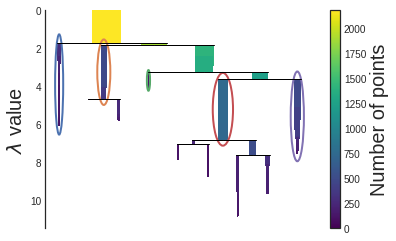

In [140]:
_=clf.hdbscan_.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette("deep", np.unique(labels).shape[0]),
)

In [141]:
df['hbscan'] = labels

# Conclusion

Let's compare all algorithms with the best scores:


**KMeans 15 clusters:**

*   Silhouette Coefficient: 0.451
*   Calinski-Harabasz Index (The higher the better): 4249.823
*   Davies-Bouldin Index (Close to 0 the best): 0.784


**KMeans 3 clusters:** 

*   Silhouette Coefficient: 0.576
*   Calinski-Harabasz Index: 4509.632
*   Davies-Bouldin Index: 0.677


**Affinity propagation 3 clusters:**

*   Silhouette Coefficient: 0.573
*   Calinski-Harabasz Index: 4493.954
*   Davies-Bouldin Index : 0.686

**Spectral 3 clusters:**

*   Silhouette Coefficient: 0.520
*   Calinski-Harabasz Index: 2221.040
*   Davies-Bouldin Index: 0.781


**Agglomerative 3 clusters:**

*   Silhouette Coefficient: 0.568
*   Calinski-Harabasz Index: 4448.769
*   Davies-Bouldin Index: 0.695

**HBSCAN 5 clusters:**

*   Silhouette Coefficient: 0.450
*   Calinski-Harabasz Index: 6999.276
*   Davies-Bouldin Index: 1.773

So the best  according to Silhouette and Davies-Bouldin so far KMeans with 3 clusters. The second best is the Affinity propagation. The most similar scores to KMeans gave the Affinity propagation algorithm with scores: 

*   Homogeneity: 0.978
*   Completeness: 0.975
*   V-measure: 0.977
*   Adjusted Rand Index: 0.986
*   Adjusted Mutual Information: 0.977

As a density-based clustering algorythms I have tried HBSCAN and DBSCAN (from sklearn). I can't install DBCV scoring for DBSCAN, so I left only HBSCAN which has its own scorer avalable. 

The best scores are with 3 clusters, but there are 20 seismic zones actually, so visualizing I selected the HBSCAN results with 5 clusters. 



In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2177 entries, 0 to 2177
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Focal depth  2177 non-null   int64   
 1   Latitude     2177 non-null   float64 
 2   Longitude    2177 non-null   float64 
 3   Richter      2177 non-null   category
 4   pca_x        2177 non-null   float64 
 5   pca_y        2177 non-null   float64 
 6   kmeans       2176 non-null   float64 
 7   affinity     2177 non-null   int64   
 8   hbscan       2177 non-null   int64   
dtypes: category(1), float64(5), int64(3)
memory usage: 155.5 KB


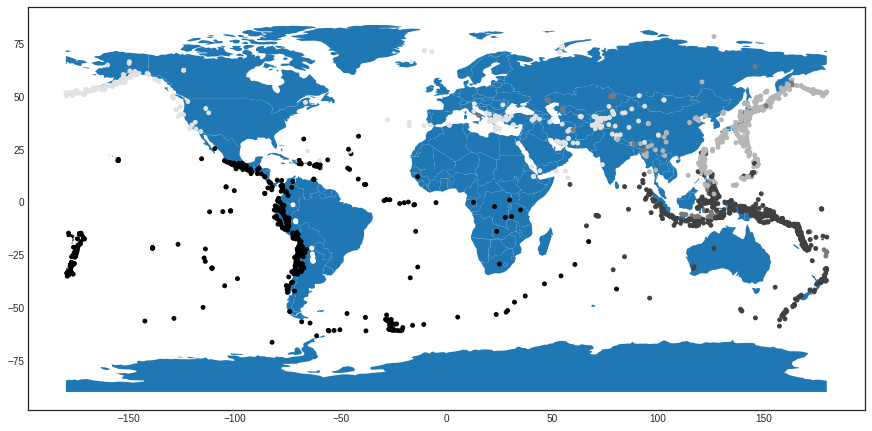

In [143]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(15, 10)), c=df['hbscan'], 
         markersize=15);

I have tried different `cmap` but it somehow mess with clusters and they are not visible anymore. There are 4 big clusters visible and some noice mixed with 5th small cluster. 